# Assignment 10
### Alexander M. Procton / 4.6.2018

For this assignment I will be attempting to implement Bayesian estimation of the difference between two groups' means and standard deviations, following the example from pymc3 documentation [here](http://docs.pymc.io/notebooks/BEST.html).

I will simulate two normally distributed variables using `numpy.random`, called `treat` and `control`, similar to the outcome of a clinical drug trial. `treat` will have a larger mean, but also a larger standard deviation.

In [1]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

#### Generate the random data

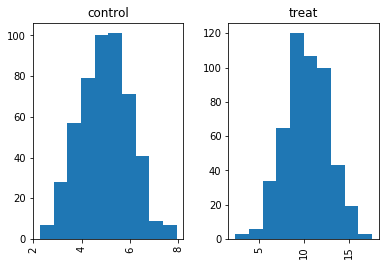

In [3]:
# set random seed
np.random.seed(4321)

# true values for mean and sd of two variables
nsize = 500
true_mu1 = 5
true_mu2 = 10
true_sig1 = 1
true_sig2 = 2.5

# generate variables
control = np.random.normal(true_mu1, true_sig1, nsize)
treat   = np.random.normal(true_mu2, true_sig2, nsize)

data = pd.DataFrame(dict(value=np.r_[control, treat], group=np.r_[['control']*nsize, ['treat']*nsize]))

# plot histograms by group
data.hist('value', by='group');

#### Generate the prior distributions

As in the pymc3 example, I will use normal distributions as my priors for the means of each group, with the pooled sample mean and twice the sample pooled standard deviation as the hyperparameters.

In [4]:
mu_mean = data.value.mean()
mu_sd   = data.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu_mean, sd=mu_sd)
    group2_mean = pm.Normal('group2_mean', mu_mean, sd=mu_sd)

I will use a uniform distribution as the prior for the standard deviations of the groups. This distribution will range from 0 to 10, which I will assume is reasonable given the expected range of measured values in this trial (in reality, I know this range is reasonable because I generated the data with known standard deviations).

In [5]:
sig_low = 0
sig_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=sig_low, upper=sig_high)
    group2_std = pm.Uniform('group2_std', lower=sig_low, upper=sig_high)

Again following the pymc3 example, I assume an equal number of degrees of freedom for each group and provide an exponential prior with a mean of 30.

In [6]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

#### Specify and fit the model

Now all that remains to specify the _t_-distributions is to convert standard deviation into precision.

In [7]:
with model:
    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.StudentT('control', nu=ν, mu=group1_mean, lam=lam1, observed=control)
    group2 = pm.StudentT('treat', nu=ν, mu=group2_mean, lam=lam2, observed=treat)

In addition to each group's mean and standard deviation, I will estimate the difference of means and the difference of standard deviations between the two groups.

In [8]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)

In [18]:
with model:
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3500/3500 [00:15<00:00, 224.63it/s]


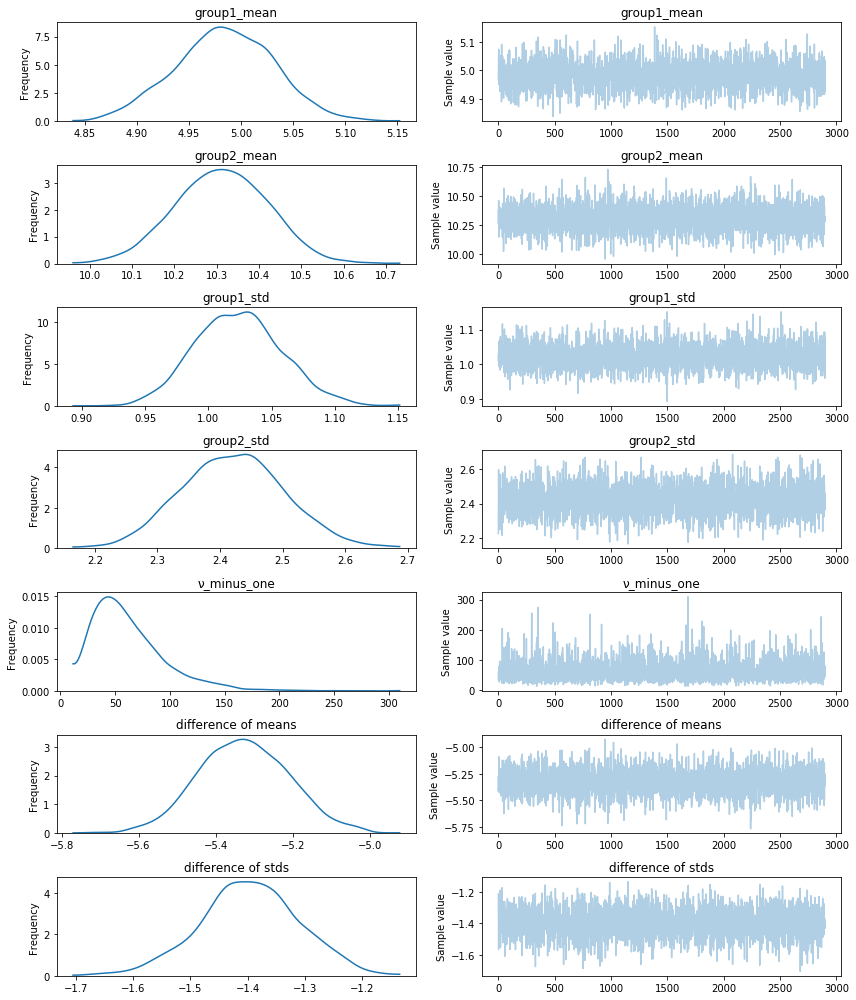

In [19]:
pm.traceplot(trace[100:]);

In [20]:
pm.summary(trace[100:])


group1_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.984            0.047            0.001            [4.891, 5.071]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.891          4.952          4.984          5.016          5.071


group2_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.310           0.109            0.002            [10.089, 10.507]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  10.095         10.236         10.311         10.385         10.517


group1_std:

  Mean             SD               MC Error         95% HPD interval
  -----

#### Summary

This model did a fairly good job of predicting the parameters I used to generate the data. The mean of the control group and the standard deviations of both groups are within the 95% HPD intervals for those parameters. However, the model overestimated the mean of the treatment group, which seems to have led to an overestimation of the difference in the means. Increasing the number of iterations for the MCMC sampler to 10000 did not improve this issue.

While putting this notebook together, I learned that pymc3 is not very forgiving if you run code specifying part of the model more than once. I was able to solve this by shutting down jupyter from the shell and starting a new notebook session.